In [1]:
import numpy as np
import pandas as pd                                                                                                                                                                                                                                                                                                                                        
import cv2
import matplotlib.pyplot as plt
import warnings                                                                                                                                                                                                         
warnings.filterwarnings("ignore")                                                                                                               
import spectral.io.envi as envi
import spectral as spy                                                                                                                                                                                                                                                                                                                                                                                                      
from spectral import open_image
import os                                                                                       
import torch                                                                                                                                                                    
import torchvision.transforms as transforms                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
from math import floor                                                                                  

In [2]:
transform = transforms.Compose([transforms.Resize((170, 170)), transforms.ToTensor()])

In [1]:
X = []
Y = []                                                                                                                                  
count_invalid = 0
invalid_photos = []                                                                                                                                                                                                                                                                 
for image_name in os.listdir("Avocado/png"):
    try:
        image = cv2.imread("Avocado/png/"+image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        tensor = transform(image)
        if os.path.exists("Avocado/hdr/"+image_name[:-4]+".hdr"):
            X.append(tensor)
            print(X)
            spectr = envi.open(file = "Avocado/hdr/"+image_name[:-4]+".hdr", image = "Avocado/hdr/"+image_name[:-4]+".hdr")
            date = spectr.metadata['acquisition date']
            Y.append(f"{image_name[0]}"+date)
            #print(date)

    except TypeError:
        count_invalid+=1
        invalid_photos.append(image_name)
X = torch.stack(X)
#Y = torch.Tensor(Y)
print(f"Количество битых фоток: {count_invalid}\nОт общего числа фоток: {count_invalid/len(os.listdir('Avocado/png'))}")

NameError: name 'cv2' is not defined

In [24]:
Y_ser = pd.Series(Y)
Y_group = Y_ser.apply(lambda x: x[0])
Y_date = Y_ser.apply(lambda x: x[1:])
Y_df = pd.DataFrame({"group": Y_group, "date": Y_date})

In [25]:
Y_df

,group,date
0,2,18-09-2021
1,4,19-01-2022
2,3,04-09-2021
3,3,06-09-2021
4,5,11-09-2021
...,...,...
1151,4,14-01-2022
1152,4,14-01-2022
1153,4,14-01-2022
1154,2,19-09-2021


In [26]:
from datetime import datetime

In [27]:
Y_df.date = Y_df.date.apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))

In [28]:
Y_df.date.unique()

array(['2021-09-18T00:00:00.000000000', '2022-01-19T00:00:00.000000000',
       '2021-09-04T00:00:00.000000000', '2021-09-06T00:00:00.000000000',
       '2021-09-11T00:00:00.000000000', '2021-07-21T00:00:00.000000000',
       '2021-09-15T00:00:00.000000000', '2021-09-22T00:00:00.000000000',
       '2022-01-16T00:00:00.000000000', '2021-08-15T00:00:00.000000000',
       '2022-01-14T00:00:00.000000000', '2022-01-18T00:00:00.000000000',
       '2021-09-07T00:00:00.000000000', '2021-09-09T00:00:00.000000000',
       '2021-09-17T00:00:00.000000000', '2021-09-21T00:00:00.000000000',
       '2021-09-05T00:00:00.000000000', '2022-01-17T00:00:00.000000000',
       '2022-01-20T00:00:00.000000000', '2021-07-20T00:00:00.000000000',
       '2021-09-13T00:00:00.000000000', '2021-09-10T00:00:00.000000000',
       '2021-09-19T00:00:00.000000000', '2021-07-19T00:00:00.000000000',
       '2022-01-13T00:00:00.000000000', '2021-09-14T00:00:00.000000000',
       '2022-01-22T00:00:00.000000000', '2021-09-20

In [29]:
min_date = []
for i in range(0, 6):
    
    min_date.append(Y_df[Y_df.group==str(i)].date.min())

In [30]:
min_date

[Timestamp('2021-07-19 00:00:00'),
 Timestamp('2021-08-15 00:00:00'),
 Timestamp('2021-09-17 00:00:00'),
 Timestamp('2021-09-04 00:00:00'),
 Timestamp('2022-01-13 00:00:00'),
 Timestamp('2021-09-09 00:00:00')]

In [31]:
day_number = Y_df.date
for i in range(0, 6):
    day_number[Y_df.group==str(i)] = Y_df.date[Y_df.group==str(i)].apply(lambda x: x-min_date[i])

In [32]:
day_number.value_counts()

1 days    195
2 days    195
5 days    149
0 days    144
4 days    143
3 days    138
6 days     95
7 days     45
8 days     29
9 days     23
Name: date, dtype: int64

In [33]:
Y_df["day_number"] = day_number

In [34]:
Y_df["day"] = Y_df.date.apply(lambda x: x.days)

In [35]:
Y_df = Y_df.drop(columns = ["day_number", "date"])

In [36]:
Y_df

,group,day
0,2,1
1,4,6
2,3,0
3,3,2
4,5,2
...,...,...
1151,4,1
1152,4,1
1153,4,1
1154,2,2


In [37]:
Y = torch.Tensor(Y_df["day"].tolist())

In [38]:
Y.shape

torch.Size([1156])

In [39]:
X.shape

torch.Size([1156, 3, 512, 512])

In [40]:
train_size = floor(len(Y_df["day"])*0.8)

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F

# Определяем класс для загрузки данных
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index].long() 

        x = transforms.ToPILImage()(x)  # преобразуем тензор в PIL Image
        if self.transform:
            x = self.transform(x)
        #x = transforms.ToTensor()(x)  # преобразуем PIL Image в тензор

        return x, y

    def __len__(self):
        return len(self.data)

In [42]:
train_data = X[:900]
train_target = Y[:900]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = MyDataset(train_data, train_target, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

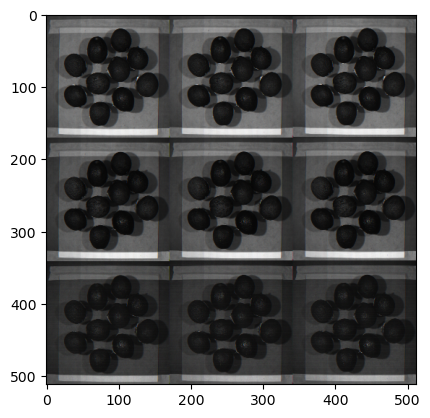

In [46]:
plt.imshow(np.reshape(X[1], (512, 512, 3)))

In [44]:
# Обучаем модель
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # Обучаем модель на 10 эпохах
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:    # Печатаем статистику каждые 10 батчей
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

KeyboardInterrupt: 

In [ ]:
torch.save(X, "X.pt")
torch.save(Y, "y.pt")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_data = X[900:]
test_target = Y[900:]

testset = MyDataset(test_data, test_target, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# Получаем предсказания модели на тестовых данных
y_pred = []
y_true = []
for data in testloader:
    inputs, labels = data
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted.numpy())
    y_true.extend(labels.numpy())

# Вычисляем метрики
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.234375
Precision: 0.20584988962472406
Recall: 0.18254734326162897
F1-score: 0.15596271929824562


In [ ]:
compare = pd.DataFrame([y_true, y_pred])

In [ ]:
compare.transpose().tail(20)

,0,1
236,1,7
237,9,6
238,2,2
239,1,2
240,4,2
241,6,6
242,5,6
243,1,2
244,4,2
245,1,7
